In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter
import warnings

warnings.filterwarnings("ignore")


# Airline Passenger Satisfaction Analysis
 


In [2]:
train_df = pd.read_csv("test.csv", index_col=0)
train_df.drop("id", axis=1, inplace=True)
test_df = pd.read_csv("train.csv", index_col=0)
test_df.drop("id", axis=1, inplace=True)


In [3]:
train_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


<a id = "2"></a><br>
# Variable Description
1. id : Unique id number to each passenger.
2. Gender: Gender of the passengers (Female, Male)
3. Customer Type: The customer type (Loyal customer, disloyal customer)
4. Age: The actual age of the passengers
5. Type of Travel: Purpose of the flight of the passengers (Personal Travel, Business Travel)
6. Class: Travel class in the plane of the passengers (Business, Eco, Eco Plus)
7. Flight distance: The flight distance of this journey
8. Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)
9. Departure/Arrival time convenient: Satisfaction level of Departure/Arrival time convenient
10. Ease of Online booking: Satisfaction level of online booking
11. Gate location: Satisfaction level of Gate location
12. Food and drink: Satisfaction level of Food and drink
13. Online boarding: Satisfaction level of online boarding
14. Seat comfort: Satisfaction level of Seat comfort
15. Inflight entertainment: Satisfaction level of inflight entertainment
16. On-board service: Satisfaction level of On-board service
17. Leg room service: Satisfaction level of Leg room service
18. Baggage handling: Satisfaction level of baggage handling
19. Check-in service: Satisfaction level of Check-in service
20. Inflight service: Satisfaction level of inflight service
21. Cleanliness: Satisfaction level of Cleanliness
22. Departure Delay in Minutes: Minutes delayed when departure
23. Arrival Delay in Minutes: Minutes delayed when Arrival
24. Satisfaction: Airline satisfaction level(satisfied, neutral or dissatisfaction)

<a id = "7"></a><br>
# Outlier Detection


In [4]:
def detect_outliers(df,features):
    outlier_indices=[]
    
    for c in features:
        # 1st quartile
        Q1=np.percentile(df[c],25)
        
        # 3rd quartile
        Q3=np.percentile(df[c],75)
        
        # IQR
        IQR= Q3-Q1
        
        # Outlier Step
        outlier_step= IQR * 1.5
        
        # Detect outlier and their indeces 
        outlier_list_col = df[(df[c]< Q1 - outlier_step)|( df[c] > Q3 + outlier_step)].index
        
        # Store indices 
        outlier_indices.extend(outlier_list_col)
    
    outliers_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i , v in outliers_indices.items() if v>2 )
    return multiple_outliers

In [5]:
#Checking for Null Values
train_df.isnull().sum()

Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0
dtype: int64

In [6]:
#Since the arrival delay in minutes has null values we replace those null
#values by zeros
train_df["Arrival Delay in Minutes"] = train_df["Arrival Delay in Minutes"].fillna(0)

In [7]:
# Droping outliers
train_df = train_df.drop(detect_outliers(train_df,[ "Age",
            "Flight Distance",
            "Inflight wifi service",
            "Departure/Arrival time convenient",
            "Ease of Online booking",
            "Gate location",
            "Food and drink",
            "Online boarding",
            "Seat comfort",
            "Inflight entertainment",
            "On-board service",
            "Leg room service",
            "Baggage handling",
            "Checkin service",
            "Inflight service",
            "Cleanliness",
            "Departure Delay in Minutes",
            "Arrival Delay in Minutes",]),axis = 0).reset_index(drop = True)

In [8]:
train_df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


Gender and Satisfaction

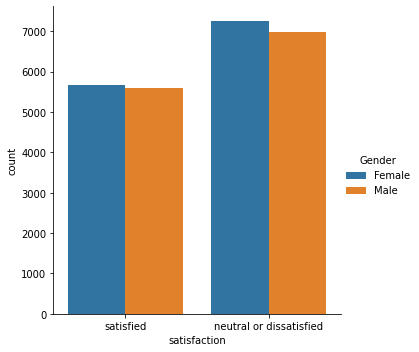

In [13]:
import seaborn as sns
gender_satisfaction = sns.catplot(x="satisfaction", 
                hue="Gender",  
                data=train_df, kind="count")  


* No of males and females who are satisfied with the airline is about the same


 Age and Satisfaction

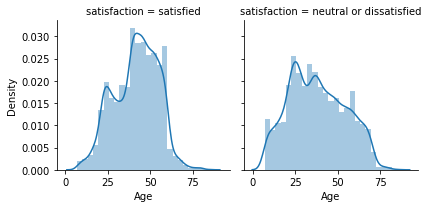

In [12]:
#Distribution of Age and thier satisfaction
g= sns.FacetGrid(train_df,col="satisfaction")
g.map(sns.distplot,"Age",bins=25)
plt.show()
# 0=neutral or dissatisfied, 1=satisfied 

Type of Travel and Satisfaction

In [37]:
train_df["Type of Travel"].value_counts()

Business travel    18038
Personal Travel     7938
Name: Type of Travel, dtype: int64

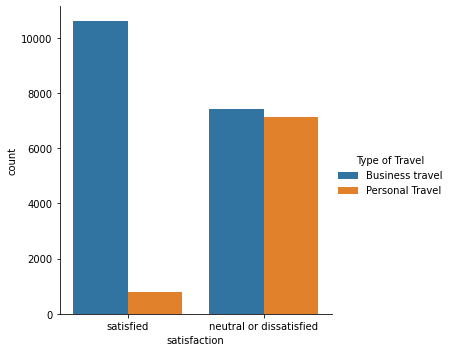

In [36]:
travel_satisfaction = sns.catplot(x="satisfaction", hue="Type of Travel", data=train_df, kind="count")


Inflight wifi service and satisfaction

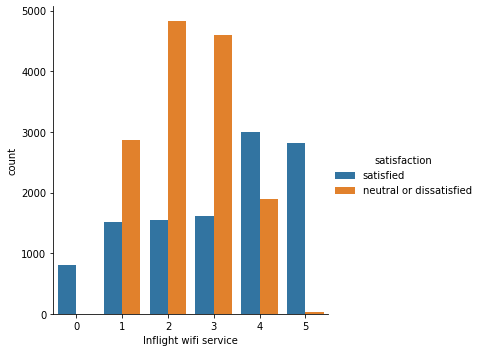

In [51]:
travel_satisfaction = sns.catplot(x="Inflight wifi service",hue="satisfaction",data=train_df,kind="count")


Inflight wifi service rated more than 3 were satisfied with airlines service

Seat Comfort and satisfaction

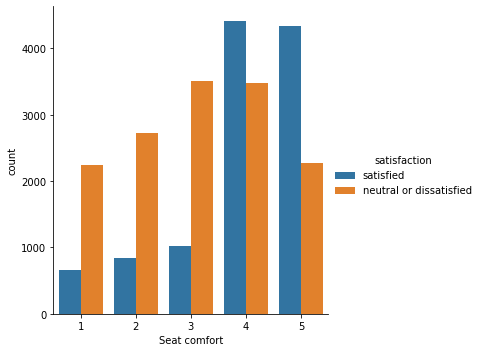

In [54]:
seat_comfort = sns.catplot(x="Seat comfort",hue="satisfaction",data=train_df,kind="count")

People who rated the seat comfort more than 3 are satisfied with the airlines service.

Cleanliness and satisfaction

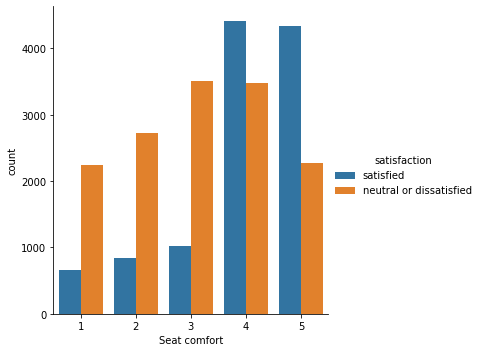

In [56]:
cleanliness_satisfaction = sns.catplot(x="Cleanliness",hue="satisfaction",data=train_df,kind="count")

People who rated the cleanliness more than 3 are satisfied with the airlines service.

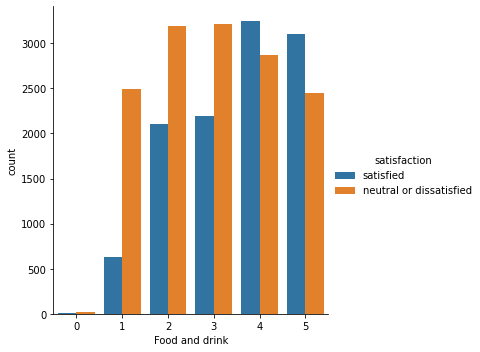

In [61]:
food_drink = sns.catplot(x="Food and drink",hue="satisfaction",data=train_df,kind="count")

Most people who rated the food drink score below 2 where not satisfied with the airline service